Kelompok : 4
Terkait Dataset : https://www.kaggle.com/datasets/novalsofyan/dtm1kv1/data

### Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/dataset_citra_tebu/dtm1k')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2
import os
from skimage.feature import graycomatrix, graycoprops
import seaborn as sns

### Data Collection

In [ ]:
# Tebu sehat
tebu_sehat = glob('/content/drive/My Drive/dataset_citra_tebu/dtm1k/train/healthy/*.JPG') + \
             glob('/content/drive/My Drive/dataset_citra_tebu/dtm1k/test/healthy/*.JPG')

# Tebu berpenyakit
tebu_penyakit = glob('/content/drive/My Drive/dataset_citra_tebu/dtm1k/train/redrot/*.JPG') + \
                glob('/content/drive/My Drive/dataset_citra_tebu/dtm1k/train/rust/*.JPG') + \
                glob('/content/drive/My Drive/dataset_citra_tebu/dtm1k/train/yellow/*.JPG') + \
                glob('/content/drive/My Drive/dataset_citra_tebu/dtm1k/test/redrot/*.JPG') + \
                glob('/content/drive/My Drive/dataset_citra_tebu/dtm1k/test/rust/*.JPG') + \
                glob('/content/drive/My Drive/dataset_citra_tebu/dtm1k/test/yellow/*.JPG')


### Labeling

In [ ]:
# 0 untuk tebu yang sehat, 1 untuk tebu yang berpenyakit
data_paths = tebu_sehat + tebu_penyakit
labels = [0] * len(tebu_sehat) + [1] * len(tebu_penyakit)


In [ ]:
print(f"Jumlah citra sehat: {len(tebu_sehat)}")
print(f"Jumlah citra sakit: {len(tebu_penyakit)}")

Jumlah citra sehat: 279
Jumlah citra sakit: 313


## Pre Processing

In [ ]:
# 2. Fungsi preprocessing
def preprocess_image(image_path, size=(256, 256)):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error membaca gambar: {image_path}")
        return None
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #cv ke grayscale
    img_resized = cv2.resize(img_gray, size) #Resize image
    img_blur = cv2.GaussianBlur(img_resized, (5, 5), 0) #Tambahkan noise
    img_normalized = img_blur / 255.0
    return img_normalized

# 3. Buat folder output
output_dir = "/content/preprocessed_tebu2"
os.makedirs(output_dir, exist_ok=True)

# 4. Proses & simpan citra sehat
for i, image_path in enumerate(tebu_sehat):
    processed_image = preprocess_image(image_path)
    if processed_image is not None:
        output_path = os.path.join(output_dir, f"tebu_healthy_{i}.png")
        cv2.imwrite(output_path, (processed_image * 255).astype(np.uint8))

# 5. Proses & simpan citra berpenyakit
for i, image_path in enumerate(tebu_penyakit):
    processed_image = preprocess_image(image_path)
    if processed_image is not None:
        output_path = os.path.join(output_dir, f"tebu_sick_{i}.png")
        cv2.imwrite(output_path, (processed_image * 255).astype(np.uint8))

print("Preprocessing selesai! Semua gambar telah disimpan.")


Preprocessing selesai! Semua gambar telah disimpan.


### Augmentasi

In [ ]:
import os
import glob
import cv2
import numpy as np

# Fungsi augmentasi gambar grayscale
def augment_image(image_path, augment=True):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    augmented_images = [img]  # Gambar asli

    if augment:
        # Flip horizontal
        img_flip = cv2.flip(img, 1)
        augmented_images.append(img_flip)

        # Rotasi 15 derajat
        h, w = img.shape
        M = cv2.getRotationMatrix2D((w//2, h//2), 15, 1)
        img_rotated = cv2.warpAffine(img, M, (w, h))
        augmented_images.append(img_rotated)

        # Tambah Gaussian noise
        noise = np.random.normal(0, 25, img.shape).astype(np.uint8)
        img_noisy = cv2.add(img, noise)
        augmented_images.append(img_noisy)

    return augmented_images

# Path input dari gambar hasil preprocessing
preprocessed_dir = "/content/preprocessed_tebu2"
image_paths = glob.glob(os.path.join(preprocessed_dir, "*.png"))

# Path untuk simpan hasil augmentasi
augmented_dir = "/content/augmented_tebu"
os.makedirs(augmented_dir, exist_ok=True)

# Lakukan augmentasi dan simpan
for i, path in enumerate(image_paths):
    basename = os.path.basename(path).lower()

    # Tentukan label berdasarkan nama file
    if "healthy" in basename:
        label = "healthy"
    elif "sick" in basename:
        label = "sick"
    else:
        label = "unknown"

    # Lakukan augmentasi
    augmented_images = augment_image(path)

    # Simpan semua gambar hasil augmentasi
    for j, img in enumerate(augmented_images):
        img = img.astype(np.float32) / 255.0  # Normalisasi
        output_path = os.path.join(augmented_dir, f"augmented_{label}_{i}_{j}.png")
        cv2.imwrite(output_path, (img * 255).astype(np.uint8))

print("Augmented images with labels saved successfully!")


Augmented images with labels saved successfully!


### Data Export

In [ ]:
import shutil

# Zip folder hasil preprocessing
shutil.make_archive('/content/preprocessed_tebu', 'zip', '/content/preprocessed_tebu2')
import shutil

# Zip folder hasil preprocessing
shutil.make_archive('/content/preprocessed_tebu', 'zip', '/content/preprocessed_tebu2')

# Zip folder hasil augmentasi
shutil.make_archive('/content/augmented_tebu', 'zip', '/content/augmented_tebu')

print("Folder berhasil dijadikan ZIP!")

# Zip folder hasil augmentasi
shutil.make_archive('/content/augmented_tebu', 'zip', '/content/augmented_tebu')

print("Folder berhasil dijadikan ZIP!")


Folder berhasil dijadikan ZIP!
Folder berhasil dijadikan ZIP!


## Ektraksi Fitur GLCM

In [ ]:
import glob
# Fungsi ekstraksi fitur GLCM dari citra grayscale
def extract_glcm_features(img, distances=[1], angles=[0], levels=256):
    glcm = graycomatrix(img, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    features = {
        'contrast': graycoprops(glcm, 'contrast')[0, 0],
        'dissimilarity': graycoprops(glcm, 'dissimilarity')[0, 0],
        'homogeneity': graycoprops(glcm, 'homogeneity')[0, 0],
        'energy': graycoprops(glcm, 'energy')[0, 0],
        'correlation': graycoprops(glcm, 'correlation')[0, 0],
        'ASM': graycoprops(glcm, 'ASM')[0, 0],
    }
    return features

# Folder citra hasil augmentasi
augmented_dir = '/content/augmented_tebu'
image_paths = glob.glob(os.path.join(augmented_dir, '*.png'))


# List untuk simpan hasil
data = []

for path in image_paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    features = extract_glcm_features(img)

    # Ambil label dari nama file
    basename = os.path.basename(path).lower()
    if 'healthy' in basename:
        label = 0
    elif 'sick' in basename:
        label = 1
    else:
        label = -1  # unknown

    features['label'] = label
    features['filename'] = os.path.basename(path)
    data.append(features)

# Simpan ke DataFrame
df = pd.DataFrame(data)

# Simpan ke CSV
csv_path = '/content/glcm_features_tebu.csv'
df.to_csv(csv_path, index=False)
print(f"Fitur GLCM berhasil disimpan ke: {csv_path}")


Fitur GLCM berhasil disimpan ke: /content/glcm_features_tebu.csv


### Visualisasi Outlier

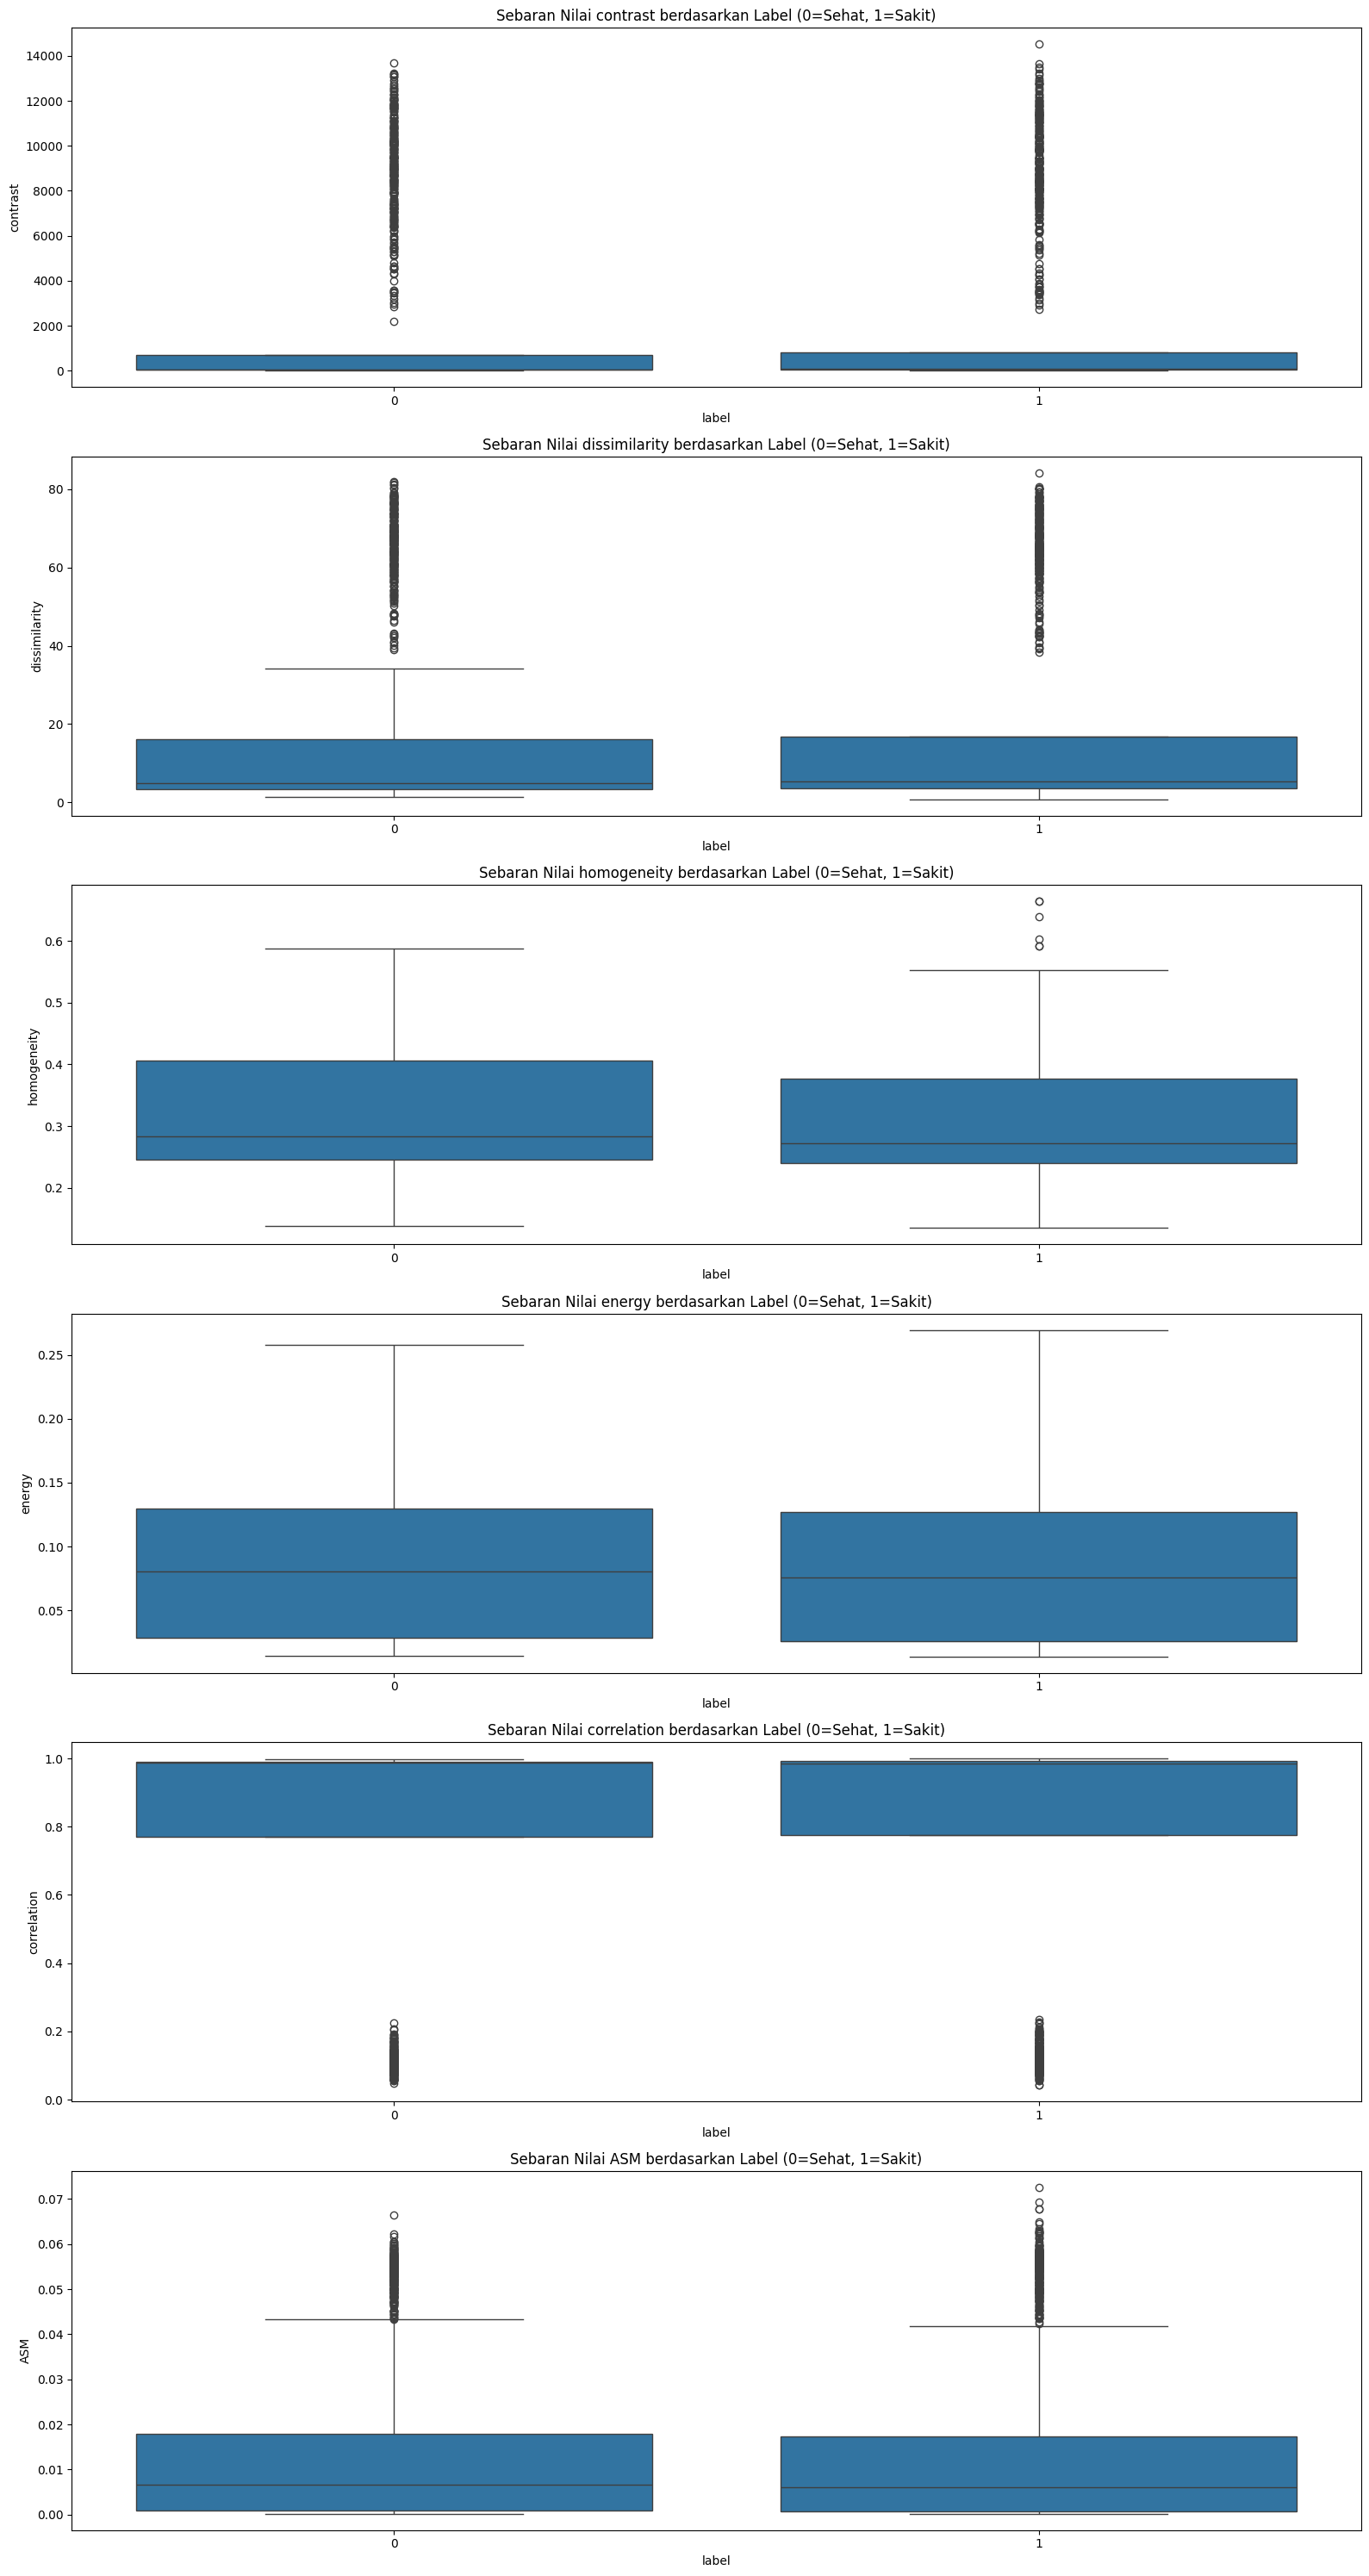

In [ ]:
# Ambil semua fitur GLCM (kecuali label dan filename)
glcm_features = df.drop(columns=['label', 'filename']).columns

# Ukuran plot
plt.figure(figsize=(16, len(glcm_features) * 5))

# Loop fitur
for i, feature in enumerate(glcm_features, 1):
    plt.subplot(len(glcm_features), 1, i)
    sns.boxplot(x='label', y=feature, data=df)
    plt.title(f'Sebaran Nilai {feature} berdasarkan Label (0=Sehat, 1=Sakit)')

plt.tight_layout()
plt.show()


Banyak outlier pada label contrast, dissimilarity, dan ASM

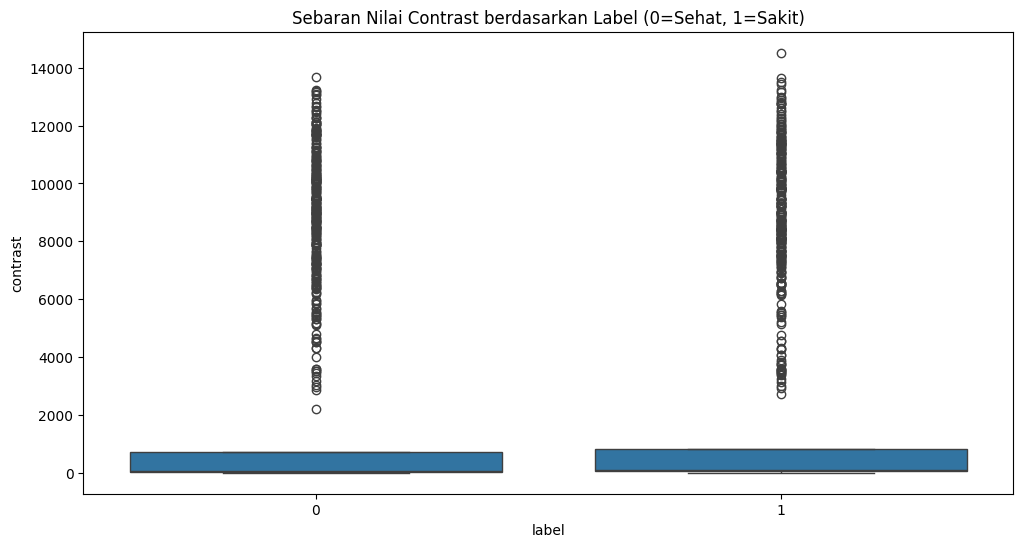

In [ ]:
# Visualisasi sebaran fitur GLCM contrast
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='contrast', data=df)
plt.title('Sebaran Nilai Contrast berdasarkan Label (0=Sehat, 1=Sakit)')
plt.show()


## HYPERPARAMETER TUNING

### Cari K Terbaik

Nilai K terbaik berdasarkan cross-validation: 1

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.76      0.72       223
           1       0.76      0.68      0.72       251

    accuracy                           0.72       474
   macro avg       0.72      0.72      0.72       474
weighted avg       0.72      0.72      0.72       474



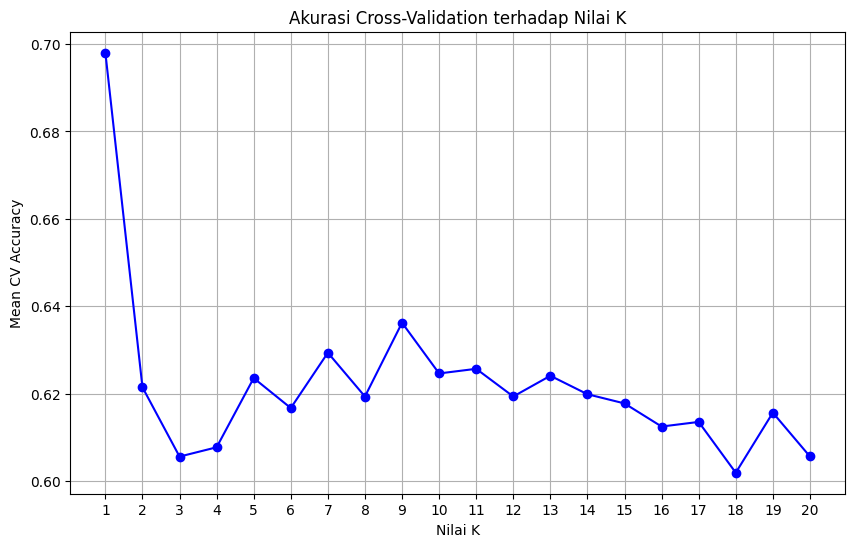

In [ ]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Load CSV hasil ekstraksi fitur GLCM
df = pd.read_csv('/content/glcm_features_tebu.csv')

# 2. Pisahkan fitur dan label
X = df.drop(columns=['label', 'filename'])  # Hapus kolom yang bukan fitur
y = df['label']  # Label: 0 = sehat, 1 = sakit

# 3. Split data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Normalisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. KNN Cross Validation (1–20)
k_values = list(range(1, 21))
mean_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    mean_scores.append(scores.mean())

# 6. Visualisasi akurasi berdasarkan nilai K
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_scores, marker='o', linestyle='-', color='blue')
plt.title('Akurasi Cross-Validation terhadap Nilai K')
plt.xlabel('Nilai K')
plt.ylabel('Mean CV Accuracy')
plt.xticks(k_values)
plt.grid(True)

# 7. Gunakan K terbaik (misalnya K = 5, atau yang tertinggi dari chart)
best_k = k_values[np.argmax(mean_scores)]
print(f"Nilai K terbaik berdasarkan cross-validation: {best_k}")

# 8. Latih model akhir dengan K terbaik
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_scaled, y_train)

# 9. Evaluasi model
y_pred = knn_final.predict(X_test_scaled)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Diketahui KNilai K terbaik = 1

## Modeling KNN

### Confusion Matrix data testing

Confusion Matrix:
[[170  53]
 [ 81 170]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.76      0.72       223
           1       0.76      0.68      0.72       251

    accuracy                           0.72       474
   macro avg       0.72      0.72      0.72       474
weighted avg       0.72      0.72      0.72       474


Akurasi: 0.7173


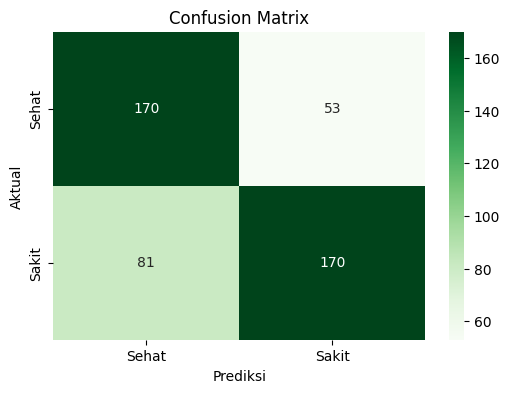

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Inisialisasi model dengan k = 1
knn = KNeighborsClassifier(n_neighbors=1)

# Latih model
knn.fit(X_train_scaled, y_train)

# Prediksi data test
y_pred = knn.predict(X_test_scaled)

# Evaluasi performa
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nAkurasi: {accuracy_score(y_test, y_pred):.4f}")

# Visualisasi confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens', xticklabels=["Sehat", "Sakit"], yticklabels=["Sehat", "Sakit"])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix")
plt.show()


### Confusion Matrix Semua Data

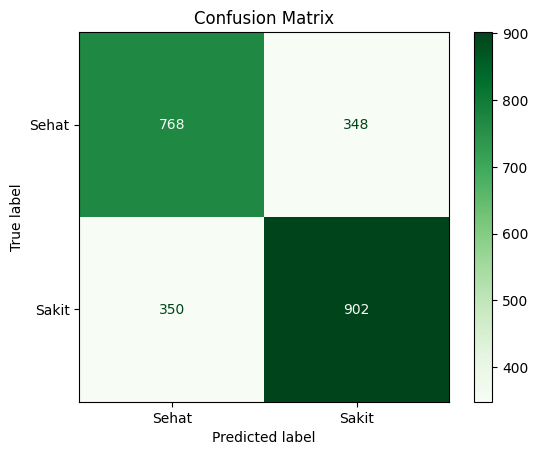

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prediksi semua data dengan cross-validation
y_pred_cv = cross_val_predict(KNeighborsClassifier(n_neighbors=best_k), X, y, cv=5)

# Tampilkan confusion matrix
cm = confusion_matrix(y, y_pred_cv)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sehat', 'Sakit'])
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.show()


### Save File Prediction

In [ ]:

# 1. Load dataset
df = pd.read_csv('/content/glcm_features_tebu.csv')

# 2. Pisahkan fitur dan label
X = df.drop(columns=['label', 'filename'])
y = df['label']

# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Normalisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Latih model KNN
best_k = 1
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)

# 6. Prediksi data uji
y_pred = knn.predict(X_test_scaled)

# 7. Simpan hasil prediksi ke DataFrame
pred_df = pd.DataFrame({
    'y_actual': y_test.values,
    'y_predicted': y_pred
})

# 8. Simpan ke CSV
pred_df.to_csv('/content/knn_predictions.csv', index=False)
print("✅ Hasil prediksi disimpan ke: /content/knn_predictions.csv")


✅ Hasil prediksi disimpan ke: /content/knn_predictions.csv
